In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Multiply, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import gc

from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')


In [3]:
def squeeze_excite_block(input_tensor, ratio=16):
    """Squeeze-and-Excitation block to refine feature maps."""
    filters = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(filters // ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    se = Reshape((1, 1, filters))(se)
    return Multiply()([input_tensor, se])

# Define dataset paths
train_dir = "/kaggle/input/iris-data/Retinal fundus images for DR/1.train"
val_dir = "/kaggle/input/iris-data/Retinal fundus images for DR/2.val"

# Image parameters
img_size = (224, 224)  # Reduced input size to save memory
batch_size = 16  # Reduced batch size to avoid OOM

# Data augmentation for training
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen_val = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = datagen_train.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = datagen_val.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load NASNetLarge model with pre-trained weights
base_model = NASNetLarge(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Apply SE attention block
x = base_model.output
x = squeeze_excite_block(x)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Callbacks
callbacks = [
    ModelCheckpoint("nasnetlarge_best_model.keras", monitor='val_accuracy', save_best_only=True, mode='max'),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
]

# Clear memory before training
tf.keras.backend.clear_session()
gc.collect()

# Train model
start_time = time.time()
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks,
    verbose=1,
)
training_time = time.time() - start_time

# Save final model
model.save("nasnetlarge_retinopathy_final.keras")

# Evaluate model
val_loss, val_acc, val_precision, val_recall = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")

# Generate Classification Report
y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
class_labels = list(val_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

Found 638 images belonging to 7 classes.
Found 136 images belonging to 7 classes.
343610240/343610240 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 653s 7s/step - accuracy: 0.2385 - loss: 2.6078 - precision: 0.2890 - recall: 0.1682 - val_accuracy: 0.3309 - val_loss: 1.8173 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.4977 - loss: 1.7142 - precision: 0.5888 - recall: 0.4055 - val_accuracy: 0.3897 - val_loss: 1.6460 - val_precision: 1.0000 - val_recall: 0.0441 - learning_rate: 1.0000e-04
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.5472 - loss: 1.3886 - precision: 0.6218 - recall: 0.4847 - val_accuracy: 0.4265 - val_loss: 1.6052 - val_precision: 1.0000 - val_recall: 0.0515 - learning_rate: 1.0000e-04
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.6725 - loss: 1.0820 - precision: 0.7272 - recall: 0.6184 - val_accuracy: 0.4338 - val_loss: 1.5111 - val_precision: 0.9375 - val_recall: 0.1103 - learning_rate: 1.0000e-04
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accura

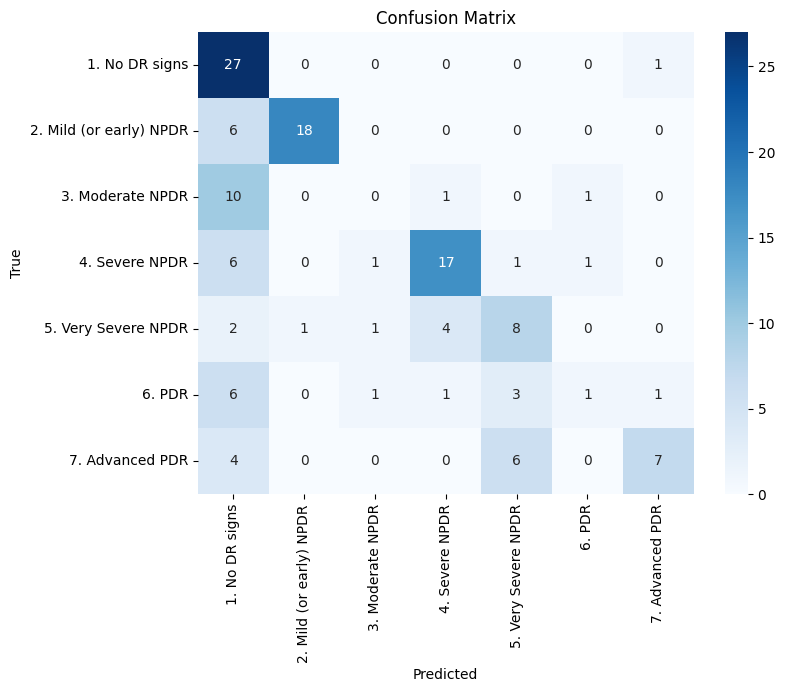

Training Time: 1057.54 seconds
Accuracy: 0.5735
Precision: 0.5264
Recall (Sensitivity): 0.4795
F1-Score: nan
Specificity: 0.8547


<ipython-input-4-95deb960104a>:18: RuntimeWarning: invalid value encountered in divide
  f1_score = 2 * (precision * recall) / (precision + recall)


In [4]:
 #Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Compute Additional Metrics
TN = np.diag(cm).sum() - cm.sum(axis=0)
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)
specificity = TN / (TN + FP)
accuracy = np.trace(cm) / np.sum(cm)

print(f"Training Time: {training_time:.2f} seconds")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {np.mean(precision):.4f}")
print(f"Recall (Sensitivity): {np.mean(recall):.4f}")
print(f"F1-Score: {np.mean(f1_score):.4f}")
print(f"Specificity: {np.mean(specificity):.4f}")

